#**Problem Statement**
In this project, we built a multiclass classification model using a custom convolutional neural network in TensorFlow.

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.


The data set contains the following diseases:

*   Actinic keratosis
*   Basal cell carcinoma
*   Dermatofibroma
*   Melanoma
*   Nevus
*   Pigmented benign keratosis
*   Seborrheic keratosis
*   Squamous cell carcinoma
*   Vascular lesion


#**Project Pipeline**

1. Data Reading/Data Understanding

2. Dataset Creation
3. Dataset visualisation
4. Model Building & training
5. Data augmentation strategy to resolve underfitting/overfitting
6. Model Building & training on the augmented data
7. Handling class imbalances
8. Model Building & training on the rectified class imbalance data

In [ ]:
# importing necessary libraries

import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_hub as hub

##**1. Data Reading/Data Understanding**
* Defining the path for train and test images

In [ ]:
# Mounting the drive to load the dataset

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/MyDrive/miniproject_dataset/miniproject_data.zip

Archive:  gdrive/MyDrive/miniproject_dataset/miniproject_data.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024707.jpg 

In [ ]:
!unzip gdrive/MyDrive/miniproject_dataset/archive.zip


Streaming output truncated to the last 5000 lines.
  inflating: train/Seborrheic Keratoses and other Benign Tumors/keloids-8.jpg  
  inflating: train/Seborrheic Keratoses and other Benign Tumors/keloids-80.jpg  
  inflating: train/Seborrheic Keratoses and other Benign Tumors/keloids-9.jpg  
  inflating: train/Seborrheic Keratoses and other Benign Tumors/keratoacanthoma-100.jpg  
  inflating: train/Seborrheic Keratoses and other Benign Tumors/keratoacanthoma-101.jpg  
  inflating: train/Seborrheic Keratoses and other Benign Tumors/keratoacanthoma-102.jpg  
  inflating: train/Seborrheic Keratoses and other Benign Tumors/keratoacanthoma-103.jpg  
  inflating: train/Seborrheic Keratoses and other Benign Tumors/keratoacanthoma-104.jpg  
  inflating: train/Seborrheic Keratoses and other Benign Tumors/keratoacanthoma-105.jpg  
  inflating: train/Seborrheic Keratoses and other Benign Tumors/keratoacanthoma-106.jpg  
  inflating: train/Seborrheic Keratoses and other Benign Tumors/keratoacanthom

In [ ]:
#train and test images dividing
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')


##**2. Dataset Creation**
* Creating train & validation dataset from the train directory with a batch size of 32
* Resizing your images to 180*180



In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)



2239
118


In [ ]:
#def batch size and img size
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
#80% data for train and 20% for validation
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
# Validation dataset loading

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


##**3. Dataset visualisation**
* Visualize one instance of all the nine classes present in the dataset



In [ ]:
# Observing the different classes

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


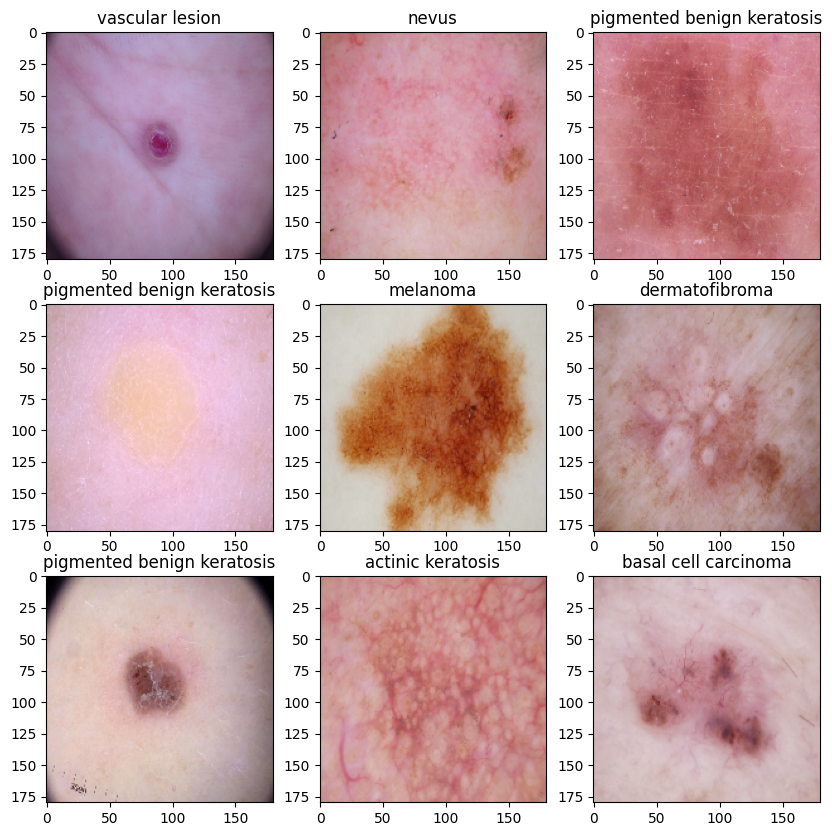

In [ ]:
#visualizing the data
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("on")

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE) #cache keep image in memory after loading from disk
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE) #prefetch overlaps data preprocessing and model execution while training

##**4. Model Building & training**


* Creating a CNN model, which can accurately detect 9 classes present in the dataset
* Normalizing pixel values between (0,1)
* Choose an appropriate optimiser and loss function for model training
* Train the model for ~20 epochs
* check if there is any evidence of model overfit or underfit

In [ ]:
# # model try no:1
# # defining model
# # (layers.experimental.preprocessing.Rescaling) to normalize pixel values between (0,1)
# num_classes = 10

# model = Sequential([
#   layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(32, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(64, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Flatten(),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(num_classes)
# ])


In [ ]:
# # optimiser and loss function
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

In [ ]:
# # model training
# epochs = 20
# history = model.fit(
#   train_ds,
#   validation_data=val_ds,
#   epochs=epochs
# )

In [ ]:
# #visualizing model result
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs_range = range(epochs)

# plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()

##**5. Data augmentation strategy to resolve underfitting/overfitting**

In [ ]:
# Data augmentation
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

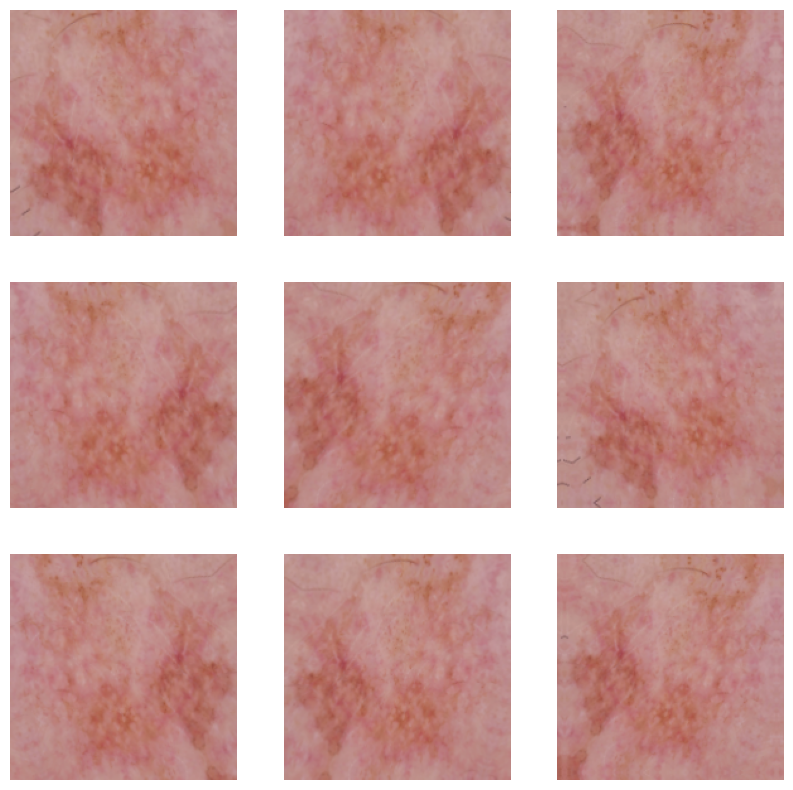

In [ ]:
#visualizing data augmentation result
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

##**6. Model Building & training on the augmented data**

In [ ]:
# #model definition try no:2
# model = Sequential([
#   data_augmentation,
#   layers.experimental.preprocessing.Rescaling(1./255),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(32, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(64, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Dropout(0.2),
#   layers.Flatten(),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(num_classes)
# ])

In [ ]:
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

In [ ]:
# #model training
# epochs = 20
# history = model.fit(
#   train_ds,
#   validation_data=val_ds,
#   epochs=epochs
# )

In [ ]:
# #visualizing the training result
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs_range = range(epochs)

# plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()

##**7. Handling class imbalances**

In [ ]:
#solving class imbalance with augmentor library
!pip install Augmentor

* Here we use the rotating augmentation technique to generate more training dataset.

In [ ]:
# Image augmentation

path_to_training_dataset="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(1500) ## adding 1000 samples

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A63F1BBF940>: 100%|██████████| 1500/1500 [01:01<00:00, 24.48 Samples/s]


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A64742E32B0>: 100%|██████████| 1500/1500 [00:52<00:00, 28.74 Samples/s]


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7A63F1B8FEE0>: 100%|██████████| 1500/1500 [00:48<00:00, 31.22 Samples/s]


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7A64701484F0>: 100%|██████████| 1500/1500 [04:18<00:00,  5.80 Samples/s]


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x7A64701AC850>: 100%|██████████| 1500/1500 [03:55<00:00,  6.37 Samples/s]


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A64701DF8E0>: 100%|██████████| 1500/1500 [00:50<00:00, 29.74 Samples/s]


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7A6403F892A0>: 100%|██████████| 1500/1500 [01:57<00:00, 12.76 Samples/s]


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7A63F1B07B80>: 100%|██████████| 1500/1500 [00:48<00:00, 31.08 Samples/s]


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A6403F890F0>: 100%|██████████| 1500/1500 [00:49<00:00, 30.06 Samples/s]


In [ ]:
path_to_training_dataset="/content/train/Acne and Rosacea Photos"
import Augmentor
# for i in class_names:
p = Augmentor.Pipeline(path_to_training_dataset)
p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
p.sample(1300) ##

Initialised with 840 image(s) found.
Output directory set to /content/train/Acne and Rosacea Photos/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=720x472 at 0x7A64525B9120>: 100%|██████████| 1300/1300 [00:59<00:00, 21.84 Samples/s]


In [ ]:
import shutil
shutil.move("/content/train/Acne and Rosacea Photos", "/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train")

'/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/Acne and Rosacea Photos'

In [ ]:
#train and test images dividing
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')


In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)



3079
118


In [ ]:
#train model on data created using augmentor
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
#spliting new data to train and validate
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 17879 files belonging to 10 classes.
Using 14304 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 17879 files belonging to 10 classes.
Using 3575 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Acne and Rosacea Photos', 'actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE) #cache keep image in memory after loading from disk
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE) #prefetch overlaps data preprocessing and model execution while training

##**8. Model Building & training on the rectified class imbalance data**

In [ ]:
#model temp
num_classes=10
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
#model training
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
447/447 [==============================] - 91s 70ms/step - loss: 1.5515 - accuracy: 0.4104 - val_loss: 1.2272 - val_accuracy: 0.5197
Epoch 2/20
447/447 [==============================] - 13s 30ms/step - loss: 1.1354 - accuracy: 0.5818 - val_loss: 1.0994 - val_accuracy: 0.5958
Epoch 3/20
447/447 [==============================] - 13s 29ms/step - loss: 0.7824 - accuracy: 0.7175 - val_loss: 0.7509 - val_accuracy: 0.7385
Epoch 4/20
447/447 [==============================] - 13s 29ms/step - loss: 0.5437 - accuracy: 0.8081 - val_loss: 0.4474 - val_accuracy: 0.8456
Epoch 5/20
447/447 [==============================] - 13s 29ms/step - loss: 0.3938 - accuracy: 0.8594 - val_loss: 0.3970 - val_accuracy: 0.8766
Epoch 6/20
447/447 [==============================] - 13s 28ms/step - loss: 0.3234 - accuracy: 0.8839 - val_loss: 0.3142 - val_accuracy: 0.8775
Epoch 7/20
447/447 [==============================] - 13s 29ms/step - loss: 0.2308 - accuracy: 0.9133 - val_loss: 0.3170 - val_accuracy:

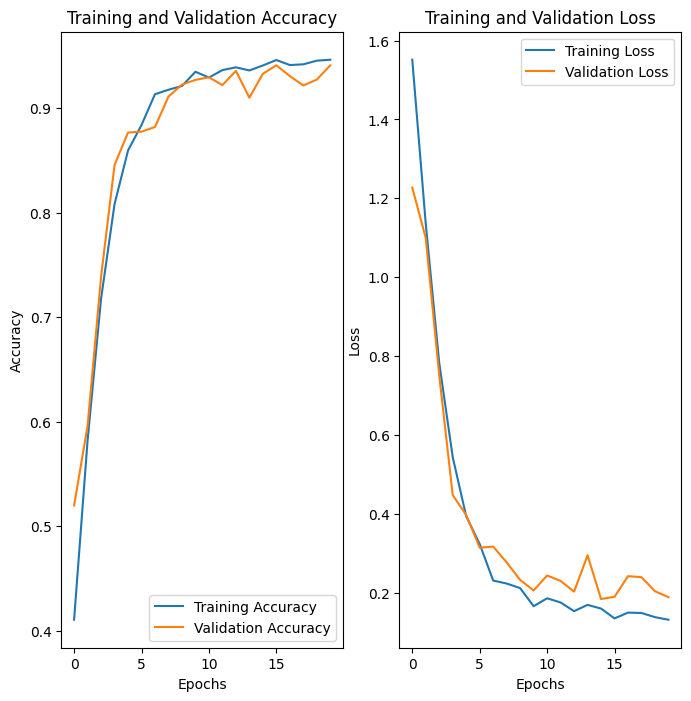

In [ ]:
#visualizing the training result
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)       

In [ ]:
from tensorflow.keras.models import load_model
model.save("/content/gdrive/MyDrive/model.h5")